## Seminar: Dealing with Word Embeddings

Today we gonna play with word embeddings: train our own little embedding, load one from   gensim model zoo and use it to visualize text corpora.

This whole thing is gonna happen on top of embedding dataset.

__Requirements:__ if you're running locally, in the selected environment run the following command:

```pip install --upgrade nltk gensim bokeh umap-learn```


In [ ]:
import string

import numpy as np
import umap
from matplotlib import pyplot as plt
from nltk.tokenize import WordPunctTokenizer  # regular-expression based tokenizer

In [ ]:
# download the data:
!wget "https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1" -O ./quora.txt -nc
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw

In [3]:
data = list(open("./quora.txt", encoding="utf-8"))
len(data)

537272

In [4]:
data[:100:10]

["Can I get back with my ex even though she is pregnant with another guy's baby?\n",
 'Which brand should go with the GTX 960 graphic card, MSI, Zotac or ASUS?\n',
 'Who discovered plate tectonics and how?\n',
 'How are Dalmatian dogs like as pets?\n',
 'What is the chemical formula for hydrochloric acid?\n',
 "What TV shows or books help you read people's body language?\n",
 'Is it possible to lick a toad and get high?\n',
 'What are the alternatives to WalkMe?\n',
 'What are some of the most epic photos ever taken?\n',
 'How do you become chancellor of a university?\n']

__Tokenization:__ a typical first step for an NLP task is to split raw data into words.
The text we're working with is in raw format: with all the punctuation and smiles attached to some words, so a simple str.split won't do.

Let's use __`nltk`__ - a library that handles many nlp tasks like tokenization, stemming or part-of-speech tagging.

In [5]:
tokenizer = WordPunctTokenizer()
tokenizer.tokenize(data[0])

['Can',
 'I',
 'get',
 'back',
 'with',
 'my',
 'ex',
 'even',
 'though',
 'she',
 'is',
 'pregnant',
 'with',
 'another',
 'guy',
 "'",
 's',
 'baby',
 '?']

In [6]:
# lowercase everything and extract tokens with tokenizer.
# data_tok should be a list of lists of tokens for each line in data.

data_tok = [tokenizer.tokenize(x.lower()) for x in data]

Let's peek at the result:

In [7]:
" ".join(data_tok[0])

"can i get back with my ex even though she is pregnant with another guy ' s baby ?"

Small check that everything is alright

In [8]:
assert all(
    isinstance(row, (list, tuple)) for row in data_tok
), "please convert each line into a list of tokens (strings)"
assert all(
    all(isinstance(tok, str) for tok in row) for row in data_tok
), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all("a" <= x.lower() <= "z" for x in tok)
assert all(
    map(lambda l: not is_latin(l) or l.islower(), map(" ".join, data_tok))
), "please make sure to lowercase the data"

### Using pre-trained model

Imagine training life-sized (100~300D) word embeddings on gigabytes of text: wikipedia articles or twitter posts.

Thankfully, nowadays you can get a pre-trained word embedding model in 2 lines of code (no sms required, promise).

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [9]:
import gensim.downloader as api

model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [10]:
model.most_similar(positive=["barcelona", "messi"], negative=["barcelona"])

[('ronaldo', 0.9686329960823059),
 ('cristiano', 0.9683733582496643),
 ('iniesta', 0.9343130588531494),
 ('falcao', 0.923397421836853),
 ('xavi', 0.9207766056060791),
 ('casillas', 0.9188492894172668),
 ('torres', 0.9028012156486511),
 ('lionel', 0.9006441831588745),
 ('barça', 0.8959811925888062),
 ('balotelli', 0.8927434086799622)]

### Visualizing word vectors

One way to see if our vectors are any good is to plot them. Thing is, those vectors are in 30D+ space and we humans are more used to 2-3D.

Luckily, we machine learners know about __dimensionality reduction__ methods.

Let's use that to plot 1000 most frequent words

In [11]:
len(model.key_to_index)

1193514

In [14]:
words = sorted(
    model.key_to_index.keys(),
    key=lambda word: model.get_vecattr(word, "count"),
    reverse=True,
)[:10000]

print(words[::100])

['<user>', '_', 'please', 'apa', 'justin', 'text', 'hari', 'playing', 'once', 'sei', 'mesmo', 'ainda', 'bang', 'radio', 'sounds', 'kinda', 'sekolah', 'dicen', 'hehehe', 'lead', 'الف', 'basketball', 'hotel', 'despues', 'din', 'earth', 'email', 'sh', 'jan', 'mucha', 'fais', 'airport', 'stfu', 'rato', 'ناس', 'شر', 'lls', 'area', 'dai', 'tenia', 'fox', 'emotional', 'scene', 'create', 'makanya', 'common', 'colombia', 'budak', 'جديد', 'και', 'gata', 'twerk', 'ketawa', 'strength', 'صحيح', 'sd', 'pilih', 'extremely', 'becomes', 'agak', 'kayo', 'rica', 'anger', 'bosen', 'hunter', 'ninja', 'frozen', 'maldita', 'adult', 'tiket', 'allá', 'tuk', 'eggs', 'ping', 'naon', 'monsters', 'drank', 'hape', 'aver', 'charles', 'rage', 'besides', 'lifetime', 'excuses', 'النفس', 'yaah', 'عنها', 'nine', 'pang', 'advantage', 'nouveau', 'teens', 'cium', 'bone', 'tracks', 'loro', 'miercoles', 'hunting', 'secretly', 'cumplir']


In [17]:
# for each word, compute it's vector with model
word_vectors = np.asarray([model[x] for x in words])

In [18]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (len(words), 25)
assert np.isfinite(word_vectors).all()

In [19]:
word_vectors.shape

(10000, 25)

#### Linear projection: PCA

The simplest linear dimensionality reduction method is PCA.

In geometric terms, PCA tries to find axes along which most of the variance occurs. The "natural" axes, if you wish.

<img src="https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/pca_fish.png" style="width:30%">


Under the hood, it attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;



In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(2)
scaler = StandardScaler()

# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
word_vectors_pca = pca.fit_transform(word_vectors)
word_vectors_pca = scaler.fit_transform(word_vectors_pca)

In [21]:
assert word_vectors_pca.shape == (
    len(word_vectors),
    2,
), "there must be a 2d vector for each word"
assert max(abs(word_vectors_pca.mean(0))) < 1e-5, "points must be zero-centered"
assert max(abs(1.0 - word_vectors_pca.std(0))) < 1e-2, "points must have unit variance"

#### Let's draw it!

In [22]:
import bokeh.models as bm
import bokeh.plotting as pl
from bokeh.io import output_notebook

output_notebook()


def draw_vectors(
    x,
    y,
    radius=10,
    alpha=0.25,
    color="blue",
    width=600,
    height=400,
    show=True,
    **kwargs,
):
    """draws an interactive plot for data points with auxilirary info on hover"""
    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({"x": x, "y": y, "color": color, **kwargs})

    fig = pl.figure(active_scroll="wheel_zoom", width=width, height=height)
    fig.scatter("x", "y", size=radius, color="color", alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig

Loading BokehJS ...

In [23]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

figure(id='p1004', ...)

### Visualizing neighbors with UMAP
PCA is nice but it's strictly linear and thus only able to capture coarse high-level structure of the data.

If we instead want to focus on keeping neighboring points near, we could use UMAP, which is itself an embedding method. Here you can read __[more on UMAP (ru)](https://habr.com/ru/company/newprolab/blog/350584/)__ and on __[t-SNE](https://distill.pub/2016/misread-tsne/)__, which is also an embedding.

In [24]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(word_vectors)

In [25]:
draw_vectors(embedding[:, 0], embedding[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

figure(id='p1053', ...)

### Visualizing phrases

Word embeddings can also be used to represent short phrases. The simplest way is to take __an average__ of vectors for all tokens in the phrase with some weights.

This trick is useful to identify what data are you working with: find if there are any outliers, clusters or other artefacts.

Let's try this new hammer on our data!


In [26]:
def get_phrase_embedding(phrase):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """
    # 1. lowercase phrase
    # 2. tokenize phrase
    # 3. average word vectors for all words in tokenized phrase
    # skip words that are not in model's vocabulary
    # if all words are missing from vocabulary, return zeros

    vector = np.zeros([model.vector_size], dtype="float32")
    phrase_tokenized = tokenizer.tokenize(phrase.lower())
    phrase_vectors = [
        model[x] for x in phrase_tokenized if x in model.key_to_index.keys()
    ]

    if len(phrase_vectors) != 0:
        vector = np.mean(phrase_vectors, axis=0)

    return vector

In [27]:
data[402687]

'What gift should I give to my girlfriend on her birthday?\n'

In [28]:
get_phrase_embedding(data[402687])

array([-0.18204999,  0.30953574,  0.20861094,  0.07982156, -0.22565515,
       -0.33001748,  1.2495784 ,  0.13134292, -0.33788875,  0.06196944,
       -0.231793  ,  0.09389219, -4.9685497 , -0.23611419, -0.32609668,
       -0.092073  ,  0.4407505 , -0.75413746, -0.5389092 , -0.184752  ,
        0.07867809,  0.20018655, -0.16202375,  0.30375698, -0.41255665],
      dtype=float32)

In [29]:
vector = get_phrase_embedding("I'm very sure. This never happened to me before...")

In [30]:
vector

array([ 0.1663555 ,  0.0534049 ,  0.01988658, -0.14495362, -0.48189807,
        0.0201319 ,  1.1701978 ,  0.39422765, -0.5707375 ,  0.07880499,
       -0.34534982, -0.0293695 , -4.785525  ,  0.04907916, -0.08470917,
        0.1303215 ,  0.03921234, -0.18863894, -0.60683554, -0.4688374 ,
        0.12880965,  0.01707016,  0.16700326,  0.4306834 , -0.05759042],
      dtype=float32)

In [31]:
# let's only consider ~5k phrases for a first run.
chosen_phrases = data[:: len(data) // 1000]

# compute vectors for chosen phrases and turn them to numpy array
phrase_vectors = np.asarray([get_phrase_embedding(x) for x in chosen_phrases])

In [32]:
assert isinstance(phrase_vectors, np.ndarray) and np.isfinite(phrase_vectors).all()
assert phrase_vectors.shape == (len(chosen_phrases), model.vector_size)

In [33]:
# map vectors into 2d space with pca, tsne or your other method of choice
# don't forget to normalize

phrase_vectors_2d = umap.UMAP(n_neighbors=3).fit_transform(phrase_vectors)

# phrase_vectors_2d = pca.fit_transform(phrase_vectors)

# phrase_vectors_2d = scaler.fit_transform(phrase_vectors_2d)
# phrase_vectors_2d = (phrase_vectors_2d - phrase_vectors_2d.mean(axis=0)) / phrase_vectors_2d.std(axis=0)

In [34]:
draw_vectors(
    phrase_vectors_2d[:, 0],
    phrase_vectors_2d[:, 1],
    phrase=[phrase[:50] for phrase in chosen_phrases],
    radius=20,
)

figure(id='p1102', ...)

Finally, let's build a simple "similar question" engine with phrase embeddings we've built.

In [35]:
# compute vector embedding for all lines in data
data_vectors = np.vstack([get_phrase_embedding(l) for l in data])

In [36]:
norms = np.linalg.norm(data_vectors, axis=1)

In [37]:
printable_set = set(string.printable)

In [38]:
data_subset = [x for x in data if set(x).issubset(printable_set)]

In [39]:
def find_nearest(query, k=10):
    """
    given text line (query), return k most similar lines from data, sorted from most to least similar
    similarity should be measured as cosine between query and line embedding vectors
    hint: it's okay to use global variables: data and data_vectors. see also: np.argpartition, np.argsort
    """
    query_vector = get_phrase_embedding(query)
    dists = data_vectors.dot(query_vector[:, None])[:, 0] / (
        (norms + 1e-16) * np.linalg.norm(query_vector)
    )
    nearest_elements = dists.argsort(axis=0)[-k:][::-1]
    out = [data[i] for i in nearest_elements]
    return out

In [40]:
results = find_nearest(query="What is life?", k=5)

print("".join(results))

What is life?
Is it true?
What is reality?
What is life like?
What is good life?



In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(3)
labels = kmeans.fit_predict(np.asarray(phrase_vectors))

In [42]:
_colors = ["red", "green", "blue"]

draw_vectors(
    phrase_vectors_2d[:, 0],
    phrase_vectors_2d[:, 1],
    color=[_colors[l] for l in labels],
    phrase=[phrase[:50] for phrase in chosen_phrases],
    radius=20,
)

figure(id='p1151', ...)

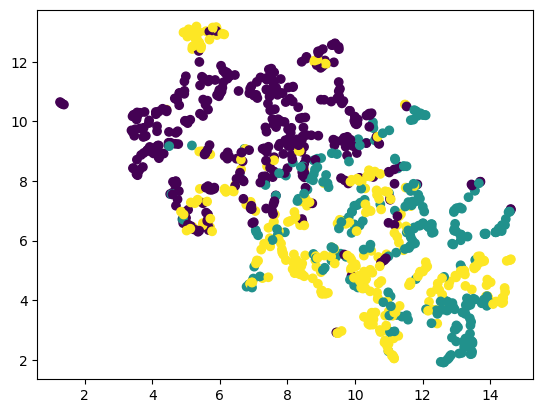

In [43]:
plt.scatter(phrase_vectors_2d[:, 0], phrase_vectors_2d[:, 1], c=labels.astype(float))

__Now what?__
* Try running TSNE instead of UMAP (it takes a long time)
* Try running UMAP or TSNE on all data, not just 1000 phrases
* See what other embeddings are there in the model zoo: `gensim.downloader.info()`
* Take a look at [FastText](https://github.com/facebookresearch/fastText) embeddings
* Optimize find_nearest with locality-sensitive hashing: use [nearpy](https://github.com/pixelogik/NearPy) or `sklearn.neighbors`.


